# Field Sampling


The particle trajectories allow us to study fields like temperature, plastic concentration or chlorophyll from a Lagrangian perspective.

In this tutorial we will go through how particles can sample `Fields`, using temperature as an example. Along the way we will get to know the parcels class `Variable` (see [here](https://parcels.readthedocs.io/en/latest/reference/particles.html#parcels.particle.Variable) for the documentation) and some of its methods. This tutorial covers several applications of a sampling setup:

- [**Basic along trajectory sampling**](#Basic-sampling)
- [**Sampling velocity fields**](#Sampling-velocity-fields)
- [**Sampling initial conditions**](#Sampling-initial-values)


## Basic sampling

We import the `Variable` class as well as the standard modules needed to set up a simulation.


In [1]:
# Modules needed for the Parcels simulation
from parcels import Variable, FieldSet, ParticleSet, JITParticle, AdvectionRK4, download_example_dataset
import numpy as np
from datetime import timedelta as delta

# To open and look at the temperature data
import xarray as xr 
import matplotlib as mpl
import matplotlib.pyplot as plt

Suppose we want to study the environmental temperature for plankton drifting around a peninsula. We have a dataset with surface ocean velocities and the corresponding sea surface temperature stored in netcdf files in the folder `"Peninsula_data"`. Besides the velocity fields, we load the temperature field using `extra_fields={'T': 'T'}`. The particles are released on the left hand side of the domain.


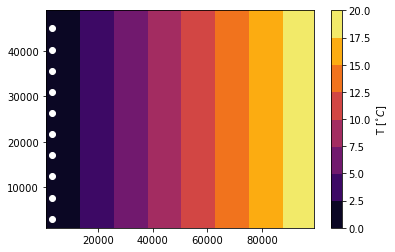

In [2]:
# Velocity and temperature fields
example_dataset_folder = download_example_dataset('Peninsula_data')
fieldset = FieldSet.from_parcels(f"{example_dataset_folder}/peninsula", extra_fields={'T': 'T'}, allow_time_extrapolation=True)

# Particle locations and initial time
npart = 10  # number of particles to be released
lon = 3e3 * np.ones(npart)
lat = np.linspace(3e3 , 45e3, npart, dtype=np.float32)
time = np.arange(0, npart) * delta(hours=2).total_seconds()  # release each particle two hours later

# Plot temperature field and initial particle locations
T_data = xr.open_dataset(f"{example_dataset_folder}/peninsulaT.nc")
plt.figure()
ax = plt.axes()
T_contour = ax.contourf(T_data.x.values, T_data.y.values, T_data.T.values[0,0], cmap=plt.cm.inferno)
ax.scatter(lon, lat, c='w')
plt.colorbar(T_contour, label='T [$^{\circ} C$]')
plt.show()

To sample the temperature field, we need to create a new class of particles where temperature is a `Variable`. As an argument for the `Variable` class, we need to provide the initial values for the particles. The easiest option is to access `fieldset.T`, but this option has some drawbacks.


In [3]:
class SampleParticle(JITParticle):         # Define a new particle class
    temperature = Variable('temperature', initial=fieldset.T)  # Variable 'temperature' initialised by sampling the temperature

pset = ParticleSet(fieldset=fieldset, pclass=SampleParticle, lon=lon, lat=lat, time=time)

Using `fieldset.T` leads to the `WARNING` displayed above because `Variable` accesses the fieldset in the slower SciPy mode. 


The solution to this initialisation problem is to leave the initial value zero and sample the initial condition in JIT mode with the sampling Kernel:


In [5]:
class SampleParticleInitZero(JITParticle):            # Define a new particle class
    temperature = Variable('temperature', initial=0)  # Variable 'temperature' initially zero

pset = ParticleSet(fieldset=fieldset, pclass=SampleParticleInitZero, lon=lon, lat=lat, time=time)

def SampleT(particle, fieldset, time):
         particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]
sample_kernel = pset.Kernel(SampleT)    # Casting the SampleT function to a kernel.

To sample the initial values we can execute the Sample kernel over the entire particleset with dt = 0 so that time does not increase


In [6]:
pset.execute(sample_kernel, dt=0) # by only executing the sample kernel we record the initial temperature of the particles

output_file = pset.ParticleFile(name="InitZero.zarr", outputdt=delta(hours=1))
pset.execute(AdvectionRK4 + sample_kernel, runtime=delta(hours=30), dt=delta(minutes=5),
             output_file=output_file)

INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\95267e2b33bce749036c721bfb587691_0.dll
INFO: Compiled SampleParticleInitZeroAdvectionRK4SampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\7e5de9a8e76698139bc7c407a0d61d6f_0.dll


The particle dataset now contains the particle trajectories and the corresponding environmental temperature


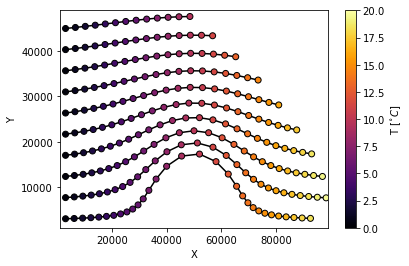

In [7]:
Particle_data = xr.open_zarr("InitZero.zarr")

plt.figure()
ax = plt.axes()
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_ylim(1000, 49000)
ax.set_xlim(1000, 99000)
ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c='k', zorder=1)
T_scatter = ax.scatter(Particle_data.lon, Particle_data.lat, c=Particle_data.temperature, 
                       cmap=plt.cm.inferno, norm=mpl.colors.Normalize(vmin=0., vmax=20.), 
                       edgecolor='k', zorder=2)
plt.colorbar(T_scatter, label='T [$^{\circ} C$]')
plt.show()

## Sampling velocity fields


Because Parcels works also for generalised curvilinear grids, you need to tread somewhat carefully when wanting to sample the velocity fields `U` and `V`. In fact, Parcels will throw a warning when directly calling a sampling of either of these fields:


In [8]:
def SampleVel_wrong(particle, fieldset, time):
    u = fieldset.U[particle]  # Parcels will throw a warning when sampling fieldset.U or fieldset.V. Use fieldset.UV instead

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, time=time)
pset.execute(SampleVel_wrong)

sh: None: command not found
INFO: Compiled ArrayJITParticleSampleVel_wrong ==> /var/folders/1p/z66v31s90c34cx9r8k4tly2w0000gv/T/parcels-507/libfb4e1b2a684d080482a96b469eb770eb_0.so


Instead, you should use the code `u, v = fieldset.UV[...]`. With this code, the sampling is consistent with the actual velocity fields used in the advection Kernels. The difference is that on a curvilinear grid, `fieldset.U[..]` returns the velocity in the `i`-direction (the columns on the grid), while `fieldset.UV[...]` returns the velocities in the longitude and latitude direction. Furthermore, only `fieldset.UV[...]` sampling can correctly deal with boundary conditions such as `freeslip` and `partialslip` ([documentation_unstuck_Agrid](https://docs.oceanparcels.org/en/latest/examples/documentation_unstuck_Agrid.html#3.-Slip-boundary-conditions))


In [9]:
def SampleVel_correct(particle, fieldset, time):
    u, v = fieldset.UV[particle]

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, time=time)
pset.execute(SampleVel_correct)

sh: None: command not found
INFO: Compiled ArrayJITParticleSampleVel_correct ==> /var/folders/1p/z66v31s90c34cx9r8k4tly2w0000gv/T/parcels-507/lib4a78f7086d7332dd9c226b1244802691_0.so


## Sampling initial values


In some simulations only the particles initial value within the field is of interest: the variable does not need to be known along the entire trajectory. To reduce computing we can specify the `to_write` argument to the temperature `Variable`. This argument can have three values: `True`, `False` or `'once'`. It determines whether to write the `Variable` to the output file. If we want to know only the initial value, we can enter `'once'` and only the first value will be written to the output file.


In [10]:
class SampleParticleOnce(JITParticle):         # Define a new particle class
    temperature = Variable('temperature', initial=0, to_write='once')  # Variable 'temperature'
    
pset = ParticleSet(fieldset=fieldset, pclass=SampleParticleOnce, lon=lon, lat=lat, time=time)

In [11]:
pset.execute(sample_kernel, dt=0) # by only executing the sample kernel we record the initial temperature of the particles

output_file = pset.ParticleFile(name="WriteOnce.zarr", outputdt=delta(hours=1))
pset.execute(AdvectionRK4, runtime=delta(hours=24), dt=delta(minutes=5),
             output_file=output_file)

INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\a7be8026cea52a1209527ece608da439_0.dll
INFO: Compiled SampleParticleOnceAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\a89daffb525400878a75fcf5f9700e46_0.dll


Since all the particles are released at the same x-position and the temperature field is invariant in the y-direction, all particles have an initial temperature of 0.4$^\circ$C


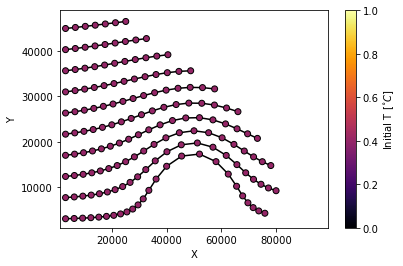

In [12]:
Particle_data = xr.open_zarr("WriteOnce.zarr")

plt.figure()
ax = plt.axes()
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_ylim(1000, 49000)
ax.set_xlim(1000, 99000)
ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c='k', zorder=1)
T_scatter = ax.scatter(Particle_data.lon, Particle_data.lat, 
                       c=np.tile(Particle_data.temperature, (Particle_data.lon.shape[1], 1)).T,
                       cmap=plt.cm.inferno, norm=mpl.colors.Normalize(vmin=0., vmax=1.), 
                       edgecolor='k', zorder=2)
plt.colorbar(T_scatter, label='Initial T [$^{\circ} C$]')
plt.show()